# Reinforcement Learning Notebook
## Introduction to Q-Learning Algorithm
This notebook is inspired by the following notebook: [Deep Reinforcement Learning Course Notebook](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/Taxi-v2/Q%20Learning%20with%20OpenAI%20Taxi-v2%20video%20version.ipynb) 



## The n-Chain environment from OpenAI Gym


The [n-Chain](https://gym.openai.com/envs/NChain-v0/) environment is taken from the OpenAI Gym module (official documentation). It is a simple, toy environment that train reinforcement learning agents.

Within the game an agent can moves along a linear chain of states, using two actions:
* action `0`: move forward along the chain, but get no reward 
* action `1`: move backward to state 0, get small reward of 2

However, the end of the chain offers a large reward of 10, and by moving 'forward' at the end of the chain this large reward can be repeatedly win.

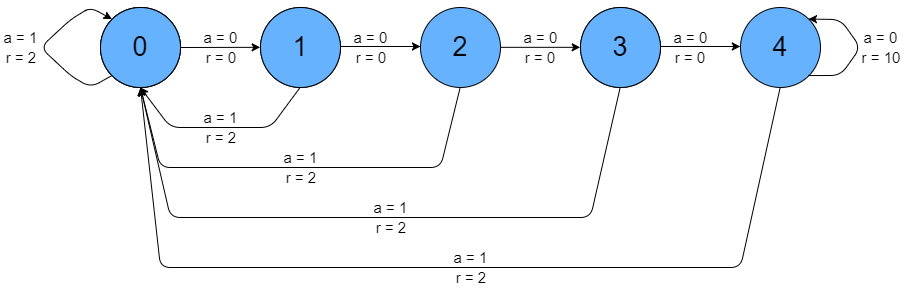

In [1]:
from IPython.display import Image
Image(filename = 'images/NChain-illustration.png', width=1000)
# source: https://adventuresinmachinelearning.com/reinforcement-learning-tutorial-python-keras/

## Idea of this notebook
Let different q-learning agents play the N-Chain evironment and see how the choosen hyperparameters change the game outcome

- 🤓 Smart Agent 1: the agent explores and takes future rewards into account
- 🤑 Greedy Agent 2: the agent cares only about immediate rewards (small gamma)
- 😳 Shy Agent 3: the agent doesn't explore the environment (small epsilon)



In [2]:
# install the gym module that contains the NChain environment
!pip install gym==0.13.1

In [3]:
# load the necessary python modules
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
import sys
import warnings
import time

# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
# initialize the nchain environment
env = gym.make('NChain-v0')

In [5]:
# get 10 randomly sampled actions
[env.action_space.sample() for ii in range(10)]

[1, 1, 1, 1, 1, 0, 1, 1, 0, 1]

In [6]:
# define the class which consists the q-learning algorithm
class QAgent(object):
    """
    Implementation of a Q-learning Algorithm
    """
    def __init__(
        self,
        env,
        name,
        color, 
        learning_parameters,
        exploration_parameters,
    ):
        """
        initialize the q-learning agent

        Args:
          name (str): set the name of the Q-Agent
          learning_parameters (dict):
          exploration_parameters (dict):

        """
        self.name = name
        self.color = color

        action_size = env.action_space.n
        state_size = env.observation_space.n

        # init the Q-table
        self.qtable = np.zeros((state_size, action_size))
        self.result = np.zeros((state_size, action_size))

        # learning parameters
        self.learning_rate = learning_parameters["learning_rate"]
        self.gamma = learning_parameters["gamma"]

        # exploration parameters
        self.epsilon = exploration_parameters["epsilon"]
        self.max_epsilon = exploration_parameters["max_epsilon"]
        self.min_epsilon = exploration_parameters["min_epsilon"]
        self.decay_rate = exploration_parameters["decay_rate"]

        self.env = env

    def q_learning(self, plot=False, max_steps=10, total_episodes=1000):
        """
        implementation of the q-learning algorithm, here the q-table values are calculated
        Args:
          plot (boolean): set true, to get trainings progress
          max_steps (int): number of stepts an agent can take, before the environment is reset
          total_episodes (int): total of training episodes (the number of trials a agent can do)
        """

        # create placeholders to store the results
        self.episode_rewards = np.zeros(total_episodes)
        self.episode_epsilon = np.zeros(total_episodes)
        self.episode_last_state = np.zeros(total_episodes)

        start = time.time()
        # loop over all episodes
        for episode_i in range(total_episodes):
            # initalize the environment
            state = self.env.reset()

            # for each episode loop over the max number of steps that are possible
            for step in range(max_steps):

                # get action, e-greedy
                action = self.get_action(state)

                # take an action and observe the outcome state (new_state), reward and stopping criterion
                new_state, reward, done, _ = self.env.step(action)

                self.qtable[state, action] = self.update_qtable(
                    state, new_state, action, reward, done
                )
                state = new_state
                self.episode_rewards[episode_i] += reward
                self.result = np.dstack((self.result, self.qtable))

                # check stopping criterion
                if done == True:
                    break

            self.episode_rewards[episode_i] /= step  # average the reward
            self.episode_last_state[episode_i] = state  # average the reward
            self.episode_epsilon[episode_i] = self.epsilon  # average the reward


            # reduce epsilon, for exploration-exploitation tradeoff
            self.update_epsilon(episode_i)

            if episode_i % 100 == 0 and plot:
                print("episode: {}".format(episode_i))
                print(
                    "\telapsed time [min]: {}".format(
                        round((time.time() - start) / 60, 1)
                    )
                )

    def update_qtable(self, state, new_state, action, reward, done):
        """
        update the q-table: Q(s,a) = Q(s,a) + lr  * [R(s,a) + gamma * max Q(s',a') - Q (s,a)]
        
        Args:
          state (int): current state of the environment
          new_state (int): new state of the environment
          action (int): current action taken by agent
          reward (int): current reward received from env
          done (boolean): variable indicating if env is done
        
        Returns:
          qtable (array): the qtable containing a value for every state (y-axis) and action (x-axis)
        """
        return self.qtable[state, action] + self.learning_rate * (
            reward
            + self.gamma * np.max(self.qtable[new_state, :]) * (1 - done)
            - self.qtable[state, action]
        )

    def update_epsilon(self, episode):
        """
        reduce epsilon, exponential decay
        
        Args:
          episode (int): number of episode
        """
        self.epsilon = self.min_epsilon + (
            self.max_epsilon - self.min_epsilon
        ) * np.exp(-self.decay_rate * episode)

    def get_action(self, state):
        """
        select action e-greedy
        
        Args:
          state (int): current state of the environment/agent
        
        Returns:
          action (int): action that the agent will take in the next step
        """
        if random.uniform(0, 1) >= self.epsilon:
            # exploitation, max value for given state
            action = np.argmax(self.qtable[state, :])
        else:
            # exploration, random choice
            action = self.env.action_space.sample()
        return action


In [7]:
action_size = env.action_space.n
state_size = env.observation_space.n

# Set the training parameters
env.env.slip = 0  # avoid slipping in on the chain
plot = False  # set true, to get printed out the trainings progress
max_steps = 10  # Set number of stepts an agent can take, before the environment is reset, 
total_episodes = 1000  # Set total of training episodes (the number of trials a agent can do)    

### 🤓 Smart Agent 1 - the agent explores and takes future rewards into account

In [8]:

name = '🤓 Smart Agent 1 - the agent explores and takes future rewards into accountt'
color = "orange"

# gamma = 1, we care about all future rewards equally as the current one 
# gamma = 0, we only care about the current reward)
# smaller decay rate, more exploration

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.9 
}  

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 1,
    'min_epsilon': 0.0,
    'decay_rate': 0.008
} 

q_agent_1 = QAgent(env, name, color, learning_parameters, exploration_parameters)

q_agent_1.q_learning(
    plot=plot, max_steps=max_steps, total_episodes=total_episodes
)

### 🤑 Greedy Agent 2 - the agent cares only about immediate rewards (small gamma)

In [9]:
name = '🤑 Greedy Agent 2 - the agent cares only about immediate rewards (small gamma)'
color =  "m"

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.01
}   

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 0.5,
    'min_epsilon': 0.0,
    'decay_rate': 0.008
} 

q_agent_2 = QAgent(env, name, color, learning_parameters, exploration_parameters)
q_agent_2.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)


### 😳 Shy Agent 3 - the agent doesn't explore the environment (small epsilon)

In [10]:
name = "😳 Shy Agent 3 - the agent doesn't explore the environment (small epsilon)"
color = "b"

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.9
} 

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 0.2,
    'min_epsilon': 0.0,
    'decay_rate': 0.5

} 

q_agent_3 = QAgent(env, name, color, learning_parameters, exploration_parameters)
q_agent_3.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)

In [11]:
from visualize_plays import VisualizePlays

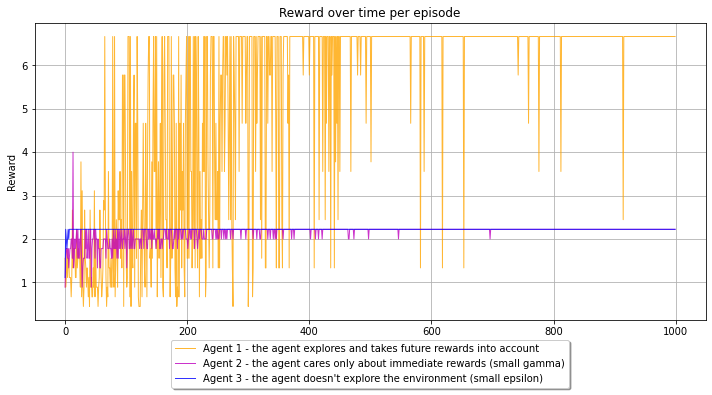

In [12]:
# visualize the different set of parameters
plays = VisualizePlays(q_agent_1, q_agent_2, q_agent_3)
plays.plot()

* y-axis: state 0 to state 4
* x-axis: action 0 and action 1
* action 0 = move forward, but get no reward (in the last state get large reward)
* action 1 = move backward to state 0, get small reward
### higher values mean higher future rewards for this specific action-state pair

In [13]:
print('case1:\n {},\n\ncase2:\n {},\n\ncase3:\n {}'.format(
    np.around(q_agent_1.qtable,1),
    np.around(q_agent_2.qtable,1),
    np.around(q_agent_3.qtable,1))
) 


case1:
 [[ 65.6  61. ]
 [ 72.9  61. ]
 [ 81.   61. ]
 [ 90.   61. ]
 [100.   61. ]],

case2:
 [[ 0.   2. ]
 [ 0.   2. ]
 [ 0.   2. ]
 [ 0.1  0. ]
 [10.1  1.6]],

case3:
 [[15.9 20. ]
 [ 0.  17.8]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]]


The q-table of case1 should have similar values like the following table:

|    ----   | Action 0  | Action 1 | 
| ------------- | ------------- | ------------- |
| state 0 | 65.61  | 61.049  |
| state 1 | 72.9  | 61.049  |
| state 2 | 81.  | 61.049  |
| state 3 | 90.  | 61.049  |
| state 4 | 100.  | 61.049  |